In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import random

In [2]:
class TextRNNmodel(nn.Module):
    def __init__(self, n_input, n_hidden, n_vocab):
        super(TextRNNmodel, self).__init__()
        self.embedding = nn.Embedding(n_vocab, n_hidden, padding_idx=0)
        self.drop1 = nn.Dropout(0.5)
        self.rnn = nn.RNN(n_hidden, n_hidden, num_layers=1, batch_first=True)
        self.out = nn.Linear(n_hidden, n_vocab)

    def forward(self, x, h=None):
        output = self.embedding(x)
        output = self.drop1(output)
        output, hp = self.rnn(output, h)
        output = self.drop1(output)
        output, hp = self.rnn(output, h)
        output = self.drop1(output)
        output = self.out(output.squeeze(1))
        return output

In [3]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    data_num = 0
    iter_num = 0

    for datas, targets in dl:
        datas, targets = datas.to(device), targets.to(device)
        data_num += len(targets)
        iter_num += 1
    
        if optimizer:
            logits = model(datas)
            loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, targets)
            
        losses += loss.item()

    return losses/iter_num, np.exp(losses/iter_num)
        

In [4]:
def make_dic_word(corpus):
    word2id = {}
    id2word = {}
    for line in corpus:
        if line == '':
            continue
        for word in line.split(' '):
            if word not in word2id:
                id = len(word2id) + 1
                word2id[word] = id
                id2word[id] = word

    id = len(word2id) + 1
    word2id['<unk>'] = id
    id2word[id] = '<unk>'
    return word2id, id2word

def encode(corpus, word2id):
    outputs = []
    for line in corpus:
        output = []
        if line == '':
            continue
        for word in line.split(' '):
            if word not in word2id:
                idx = word2id['<unk>']
            else:
                idx = word2id[word]
            output.append(idx)
        outputs.append(output)

    return outputs

def decode(sentence, id2word):
    return [id2word[id] for id in sentence]


In [5]:
def make_dic_char(corpus):
    word2id = {}
    id2word = {}
    tmp = {}
    for line in corpus:
        if line == '':
            continue
        for w in line:
            if w not in word2id:
                id = len(word2id) + 1
                word2id[w] = 1
            else:
                word2id[w] = word2id[w] + 1

    lists = sorted(word2id.items(), key=lambda x:x[1], reverse=True)
    
    word2id.clear()
    tmp.update(lists)

    for i, k in enumerate(tmp.keys()):
        word2id[k] = i
        id2word[i] = k
        
    id = len(word2id) + 1
    word2id['<unk>'] = id
    id2word[id] = '<unk>'

    print(word2id)
    print(id2word)
    return word2id, id2word

In [4]:
def make_dic_char(corpus):
    word2id = {}
    id2word = {}
    for line in corpus:
        if line == '':
            continue
        for w in line:
            if w not in word2id:
                id = len(word2id) + 1
                word2id[w] = id
                id2word[id] = w

    id = len(word2id) + 1
    word2id['<unk>'] = id
    id2word[id] = '<unk>'
    return word2id, id2word

def encode(corpus, word2id):
    outputs = []
    for line in corpus:
        output = []
        if line == '':
            continue
        for w in line:
            if w not in word2id:
                idx = word2id['<unk>']
            else:
                idx = word2id[w]
            output.append(idx)
        outputs.append(output)

    return outputs

def decode(sentence, id2word):
    return [id2word[id] for id in sentence]


In [6]:
class TextDataset(Dataset):
    def __init__(self, id_data, max_length=50):
        super().__init__()
        self.data_length = len(id_data)
        self.x = [row[0:-1] for row in id_data]
        self.y = [row[1:] for row in id_data]
        
        self.max_length = max_length
    
    def __len__(self):
        return self.data_length
    
    def __getitem__(self, idx):
        out_data = self.x[idx]
        out_label =  self.y[idx]

        out_data = pad_sequences([out_data], padding='post', maxlen=self.max_length)[0]
        out_label = pad_sequences([out_label], padding='post', maxlen=self.max_length)[0]

        out_data = torch.LongTensor(out_data)
        out_label = torch.LongTensor(out_label)

        return out_data, out_label

In [7]:
with open('TheTimeMachine.txt') as f:
    corpus = f.read()

corpus = corpus.split('\n')

word2id, id2word = make_dic_char(corpus)

{' ': 0, 'e': 1, 't': 2, 'a': 3, 'o': 4, 'n': 5, 'i': 6, 's': 7, 'r': 8, 'h': 9, 'd': 10, 'l': 11, 'u': 12, 'm': 13, 'c': 14, 'f': 15, 'g': 16, 'w': 17, 'y': 18, 'p': 19, ',': 20, '.': 21, 'b': 22, 'I': 23, 'v': 24, 'k': 25, 'T': 26, '“': 27, 'A': 28, 'x': 29, 'M': 30, 'S': 31, 'E': 32, 'P': 33, '”': 34, '—': 35, 'j': 36, 'W': 37, '-': 38, '’': 39, 'B': 40, 'F': 41, 'G': 42, 'H': 43, 'O': 44, 'N': 45, ';': 46, 'z': 47, 'q': 48, '?': 49, 'L': 50, 'R': 51, 'U': 52, 'Y': 53, 'D': 54, 'C': 55, '!': 56, '™': 57, '1': 58, ':': 59, 'V': 60, '(': 61, ')': 62, '‘': 63, '0': 64, 'X': 65, 'J': 66, '3': 67, '\t': 68, '5': 69, '2': 70, '*': 71, '/': 72, '8': 73, '9': 74, 'K': 75, '4': 76, '6': 77, 'æ': 78, '…': 79, '[': 80, ']': 81, '7': 82, '•': 83, 'Q': 84, 'œ': 85, '$': 86, '#': 87, 'ü': 88, '>': 89, 'ç': 90, '%': 91, '<unk>': 93}
{0: ' ', 1: 'e', 2: 't', 3: 'a', 4: 'o', 5: 'n', 6: 'i', 7: 's', 8: 'r', 9: 'h', 10: 'd', 11: 'l', 12: 'u', 13: 'm', 14: 'c', 15: 'f', 16: 'g', 17: 'w', 18: 'y', 19: '

EPOCH:0, Train: loss=4.21, ppl=67.0
EPOCH:5, Train: loss=2.61, ppl=13.7
EPOCH:10, Train: loss=2.38, ppl=10.9
EPOCH:15, Train: loss=2.27, ppl=9.72
EPOCH:20, Train: loss=2.21, ppl=9.1
EPOCH:25, Train: loss=2.16, ppl=8.65
EPOCH:30, Train: loss=2.11, ppl=8.26
EPOCH:35, Train: loss=2.08, ppl=7.96
EPOCH:40, Train: loss=2.04, ppl=7.71
EPOCH:45, Train: loss=2.01, ppl=7.49
EPOCH:50, Train: loss=1.99, ppl=7.31
EPOCH:55, Train: loss=1.97, ppl=7.15
EPOCH:60, Train: loss=1.95, ppl=6.99
EPOCH:65, Train: loss=1.93, ppl=6.89
EPOCH:70, Train: loss=1.91, ppl=6.77
EPOCH:75, Train: loss=1.89, ppl=6.62
EPOCH:80, Train: loss=1.88, ppl=6.57
EPOCH:85, Train: loss=1.87, ppl=6.47
EPOCH:90, Train: loss=1.85, ppl=6.37
EPOCH:95, Train: loss=1.84, ppl=6.31
Best train loss=1.82 Best train ppl=6.17


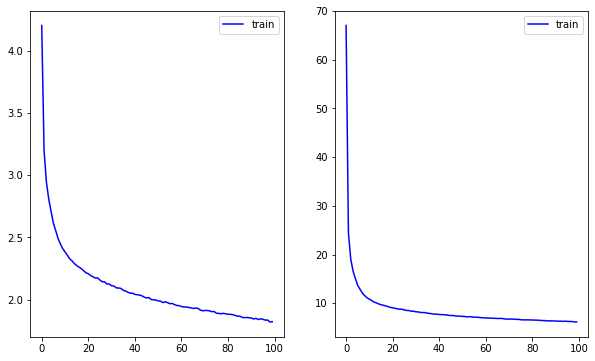

In [31]:
epoch = 100
TRAIN_BATCH_SIZE = 64
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

data_id = encode(corpus,word2id)
dataset = TextDataset(data_id)
train_dl = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, drop_last=True)

HIDDEN_DIM = 256
VOCAB_SIZE = len(id2word)
model = TextRNNmodel(50, HIDDEN_DIM, VOCAB_SIZE)
model.to(device)
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=93)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), amsgrad=True)

train_loss_list, train_ppl_list = [],[]
best_train_loss, best_train_ppl = None, None
count = 0
    
for i in range(epoch):
    loss, ppl = one_epoch(model, train_dl, device, criterion, optimizer)
    train_loss_list.append(loss)
    train_ppl_list.append(ppl)

    if i==0 or best_train_loss >= loss:
        best_train_loss = loss
        best_train_ppl = ppl
    if i%5 == 0:
        print('EPOCH:{:}, Train: loss={:.3}, ppl={:.3}'.format(i,loss, ppl))

print('Best train loss={:.3} Best train ppl={:.3}'.format(best_train_loss, best_train_ppl))

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_ppl_list, 'b', label='train')
ax2.legend()
plt.show()



In [141]:
model.eval()
morphemes = ['T', 'H', 'Y']

with torch.no_grad():
    for morpheme in morphemes:
        sentence = [morpheme]
        for _ in range(100):
            input_index = encode([morpheme], word2id)
            input_tensor = torch.tensor([input_index], device=device)
            outputs = model(input_tensor.view(-1, input_tensor.size(-1)))
            probs = nn.functional.softmax(torch.squeeze(outputs))
            p = probs.cpu().detach().numpy()
            morpheme = id2word[np.random.choice(len(p), p=p)]
            sentence.append(morpheme)
            if morpheme in ['.', "<unk>"]:
                break
        print("".join(sentence))

TH, SThere us theve unen.
HI in?” risus ned…I red CI alind.
YThon here HHIIInd .


ipykernel_launcher:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
